In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import fu, nu
from datetime import timedelta
import matplotlib.pyplot as plt
from pandas import DataFrame
import humanize
import numpy as np
import os.path as osp
import pandas as pd
import seaborn as sns

In [3]:

# Get the error free subset into the FRVRS logs DataFrame variable
if nu.csv_exists('error_free_subset_df', folder_path=nu.data_csv_folder):
    frvrs_logs_df = nu.load_csv(csv_name='error_free_subset_df')
    print(frvrs_logs_df.shape)

(256263, 114)



# Number of Patients Engaged

In [4]:

# Initialize an empty list to store the data for each session
rows_list = []

# Loop through each unique UUID and scene combination
for (session_uuid, scene_id), scene_df in frvrs_logs_df.groupby(fu.scene_groupby_columns):
    
    # Get the logger version and scene categories
    logger_version = fu.get_logger_version(scene_df)
    is_scene_aborted = fu.get_is_scene_aborted(scene_df)
    scene_type = fu.get_scene_type(scene_df)
    
    # Get the number of patients in the group
    patients_count = fu.get_patient_count(scene_df)
    
    # Initialize a counter for patients engaged in the current group
    patients_engaged = 0
    
    # Loop through each unique patient_id in the current group
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        
        # Create a mask to filter rows where action_type is 'PATIENT_ENGAGED'
        mask_series = (patient_df.action_type == 'PATIENT_ENGAGED')
        
        # If the filtered dataframe has any rows, increment the number of patients engaged
        if mask_series.any(): patients_engaged += 1
    
    # If there are any patients in the group, add a row to the results list with the following information:
    # * logger version
    # * session uuid
    # * scene
    # * number of patients in the group
    # * number of patients engaged in the group
    # * percentage of patients engaged in the group
    if patients_count:

        # Create a dictionary to store the data for the current group
        row_dict = {}
        for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
        row_dict['logger_version'] = logger_version
        row_dict['is_scene_aborted'] = is_scene_aborted
        row_dict['scene_type'] = scene_type
        row_dict['patients_count'] = patients_count
        row_dict['patients_engaged'] = patients_engaged
        row_dict['percentage_engaged'] = patients_engaged / patients_count
        
        # Append the dictionary to the list of rows
        rows_list.append(row_dict)

# Create a data frame from the list of dictionaries
percentage_engaged_df = DataFrame(rows_list)

In [5]:

# Get average number of patients engaged (this could be including the ones that wave, walk, put hands up)
mask_series = (percentage_engaged_df.scene_type == 'Triage') & (percentage_engaged_df.is_scene_aborted == False)
ave_patients_engaged = percentage_engaged_df[mask_series].patients_engaged.mean()
print(f'The average number of patients engaged per scene is {ave_patients_engaged}.')

The average number of patients engaged per scene is 10.028011204481793.


In [6]:

mask_series = (percentage_engaged_df.percentage_engaged == 0) & (percentage_engaged_df.logger_version == 1.3)
percentage_engaged_df[mask_series]

,session_uuid,scene_id,logger_version,is_scene_aborted,scene_type,patients_count,patients_engaged,percentage_engaged
23,1066671d-2a1d-4744-b66f-e4b48548701f,0,1.3,False,Triage,19,0,0.0
165,7c2549d4-97a4-4389-bd03-029396714f59,0,1.3,False,Triage,11,0,0.0
264,ccfb5502-64b5-4d1c-9ca3-63f522330041,0,1.3,False,Triage,11,0,0.0


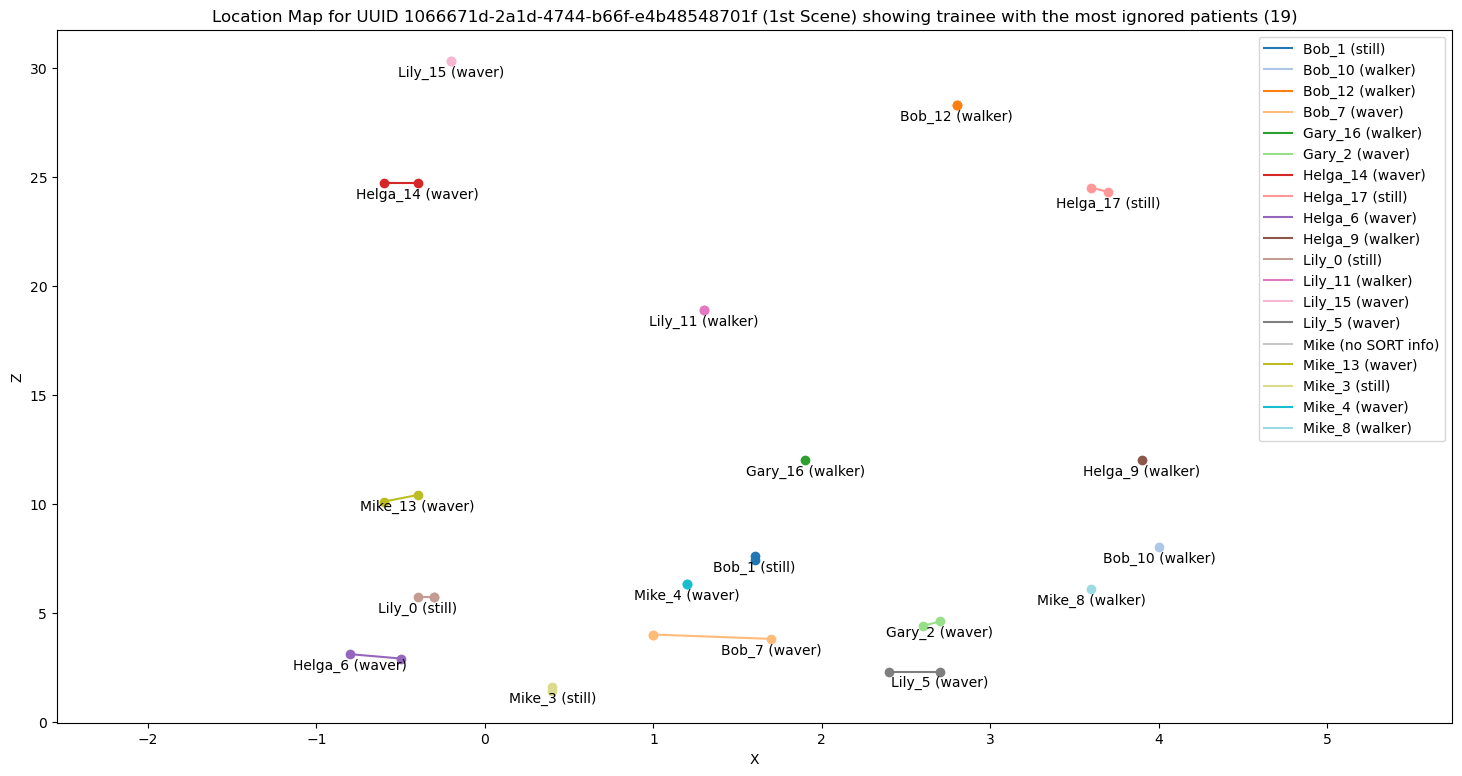

In [7]:

# Get scene with the most ignored patients, v1.3
mask_series = (percentage_engaged_df.percentage_engaged == 0) & (percentage_engaged_df.logger_version == 1.3)
fu.visualize_extreme_player_movement(
    percentage_engaged_df,
    'patients_count',
    mask_series=mask_series,
    is_ascending=False,
    humanize_type='intword',
    title_str='most ignored patients'
)


# Distribution of Percentage of Tags Correctly Applied across different Tags

In [8]:

# Iterate through each patient of each run of each session
rows_list = []
for (session_uuid, scene_id, patient_id), patient_df in frvrs_logs_df.sort_values(['action_tick']).groupby(fu.patient_groupby_columns):
    
    # Add the logger version, groupby columns, and other run characteristics to the row dictionary
    row_dict = {}
    for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
    row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(patient_df)
    row_dict['scene_type'] = fu.get_scene_type(patient_df)
    row_dict['is_a_one_triage_file'] = fu.get_is_a_one_triage_file(patient_df)
    row_dict['patient_count'] = 1

    # Get non-null tag applied types and patient record SALTs
    mask_series = ~patient_df.tag_applied_type.isnull() | ~patient_df.patient_record_salt.isnull()
    tags_and_salts_df = patient_df[mask_series]

    # Add the last tag value
    last_tag = fu.get_last_tag(tags_and_salts_df)
    row_dict['last_tag'] = last_tag

    # Add the max salt value
    max_salt = fu.get_max_salt(patient_df=tags_and_salts_df)
    row_dict['max_salt'] = max_salt
    
    # Add the predicted tag value
    try: predicted_tag = fu.salt_to_tag_dict.get(max_salt, np.nan)
    except Exception: predicted_tag = np.nan
    row_dict['predicted_tag'] = predicted_tag
    
    # Add if tag is correct
    row_dict['is_tag_correct'] = bool(last_tag == predicted_tag)

    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Store the patient history data frame
tag_to_salt_df = pd.DataFrame(rows_list)

# Convert the columns to the custom categorical type
tag_to_salt_df.last_tag = tag_to_salt_df.last_tag.astype(fu.colors_category_order)
tag_to_salt_df.max_salt = tag_to_salt_df.max_salt.astype(fu.salt_category_order)
tag_to_salt_df.predicted_tag = tag_to_salt_df.predicted_tag.astype(fu.colors_category_order)

# Sort the data frame based on the custom categorical orders
tag_to_salt_df = tag_to_salt_df.sort_values('predicted_tag')

In [9]:

# Get the total and correct counts for each run for each tag
rows_list = []
tagged_mask_series = tag_to_salt_df.last_tag.isnull() | tag_to_salt_df.max_salt.isnull()

# Add the normal section
groupby_columns = ['session_uuid', 'scene_id', 'predicted_tag']
for (session_uuid, scene_id, predicted_tag), df in tag_to_salt_df[~tagged_mask_series].groupby(groupby_columns):
    
    # Add the logger version, groupby columns, and scene categories to the row dictionary
    row_dict = {}
    for cn in groupby_columns: row_dict[cn] = eval(cn)
    row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(df)
    row_dict['scene_type'] = fu.get_scene_type(df)

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    row_dict['correct_count'] = correct_count
    total_count = df.patient_count.sum()
    row_dict['total_count'] = total_count
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Add the not-tagged section
for (session_uuid, scene_id), df in tag_to_salt_df[tagged_mask_series].groupby(fu.scene_groupby_columns):
    
    # Add the logger version, groupby columns, and scene categories to the row dictionary
    row_dict = {}
    for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    row_dict['predicted_tag'] = 'Not Tagged'
    row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(df)
    row_dict['scene_type'] = fu.get_scene_type(df)

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    row_dict['correct_count'] = correct_count
    total_count = df.patient_count.sum()
    row_dict['total_count'] = total_count
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Create the correct count data frame
correct_count_by_tag_df = pd.DataFrame(rows_list)

In [10]:

# Sample data for the violin plot
data = {
    'predicted_tag': correct_count_by_tag_df.predicted_tag.tolist(),
    'percentage_tag_correct': correct_count_by_tag_df.percentage_tag_correct.tolist()
}

# Create a DataFrame from the data and
# provide the following statistics for this distribution:
# mean, median, mode, SD, interquartile range
df = pd.DataFrame(data)
unique_tags = df.predicted_tag.unique()
display(fu.get_statistics(df, ['percentage_tag_correct']).applymap(lambda x: round(x, 2), na_action='ignore').T)

,mean,mode,median,SD,min,25%,50%,75%,max
percentage_tag_correct,73.31,100.0,100.0,38.11,0.0,50.0,100.0,100.0,100.0


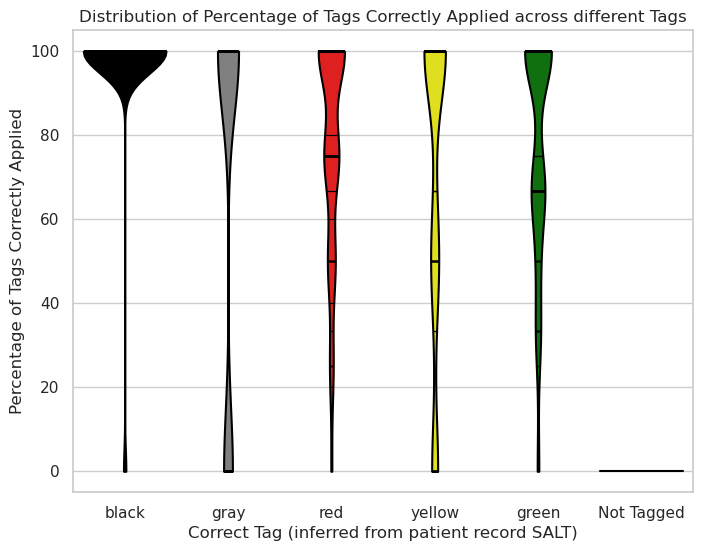

In [11]:

# Set the style of the plot
sns.set(style='whitegrid')

# Create the violin plot with 5 violins
plt.figure(figsize=(8, 6))
palette = ['white' if (color == 'Not Tagged') else color for color in unique_tags]
sns.violinplot(x='predicted_tag', y='percentage_tag_correct', data=df, palette=palette, inner='stick', cut=0.0)

# Set plot labels and title
plt.xlabel('Correct Tag (inferred from patient record SALT)')
plt.ylabel('Percentage of Tags Correctly Applied')
plt.title('Distribution of Percentage of Tags Correctly Applied across different Tags')

# Show the plot
plt.show()


# How many responders correctly tagged all patients?

In [11]:

# Get the total and correct counts for each run
rows_list = []
for (session_uuid, scene_id), df in tag_to_salt_df.groupby(fu.scene_groupby_columns):
    
    # Add the logger version, groupby columns, and scene categories to the row dictionary
    row_dict = {}
    for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(df)
    row_dict['scene_type'] = fu.get_scene_type(df)

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    row_dict['correct_count'] = correct_count
    total_count = df.patient_count.sum()
    row_dict['total_count'] = total_count
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Create the correct count data frame
correct_count_df = pd.DataFrame(rows_list)

In [12]:

mask_series = (correct_count_df.scene_type == 'Triage') & (correct_count_df.is_scene_aborted == False)
total_count = correct_count_df[mask_series].total_count.sum()
correct_count = correct_count_df[mask_series].correct_count.sum()
percentage_tag_correct = 100*correct_count/total_count
print(f'{percentage_tag_correct:.2f}% of all responders correctly tagged all patients.')

68.43% of all responders correctly tagged all patients.



# Triage Accuracy

In [13]:

# Group the data by session and scene
groupby_columns = fu.scene_groupby_columns + ['is_scene_aborted', 'scene_type', 'is_a_one_triage_file']
gb = frvrs_logs_df.groupby(groupby_columns)

# Iterate over each run to get the data rows
rows_list = []
for (session_uuid, scene_id, is_scene_aborted, scene_type, is_a_one_triage_file), scene_df in gb:
    row_dict = {}

    # Populate the row dictionary with values from the groupby_columns
    for cn in groupby_columns: row_dict[cn] = eval(cn)

    # Set the last engagement time among all the obvious life threats
    assert ('tag_applied_type' in scene_df.columns)
    mask_series = scene_df.tag_applied_type.isin(['red', 'gray', 'black'])
    df = scene_df[mask_series]
    if df.shape[0]:
        patient_ids_list = df.patient_id.unique().tolist()
        mask_series = frvrs_logs_df.patient_id.isin(patient_ids_list)
        for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
        row_dict['last_threat_engaged'] = fu.get_last_patient_interaction(frvrs_logs_df[mask_series])

    # Group the patients by their SORT category and get the last elapsed times
    sort_dict = {}
    for sort, patient_sort_df in scene_df.groupby('patient_sort'):
        if sort in fu.right_ordering_list:

            # Get the SORT's entire history
            patient_ids_list = patient_sort_df.patient_id.unique()
            mask_series = frvrs_logs_df.patient_id.isin(patient_ids_list)
            for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))

            # Add the last engaged sort
            row_dict[f'last_{sort}_engaged'] = fu.get_last_patient_interaction(frvrs_logs_df[mask_series])

    # Get an R-squared Adjusted as a measure of right ordering
    row_dict['rsquared_adj'] = fu.get_measure_of_right_ordering(scene_df)

    rows_list.append(row_dict)

engagement_sort_df = DataFrame(rows_list)

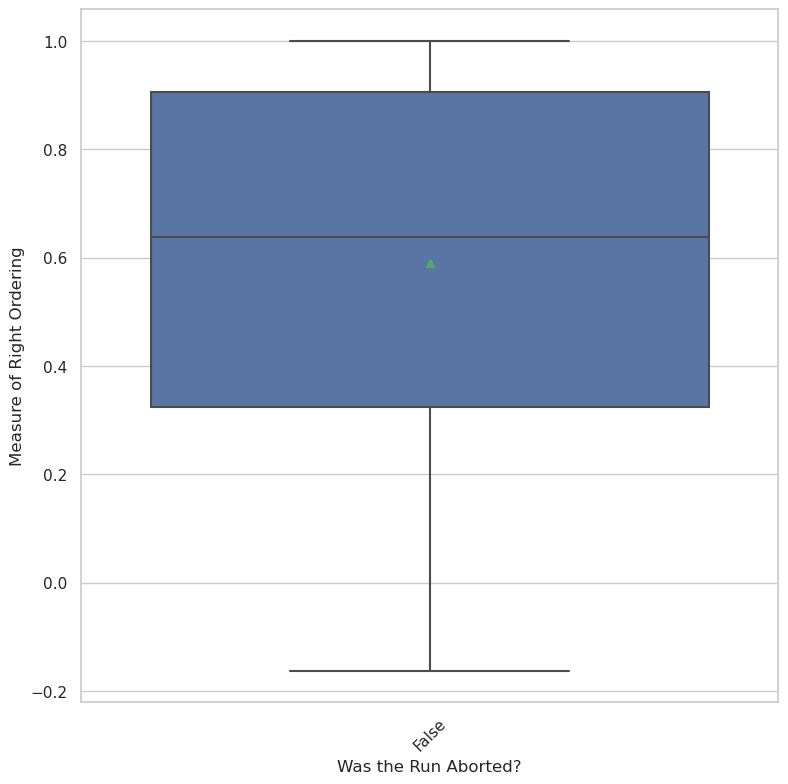

In [14]:

mask_series = (engagement_sort_df.scene_type == 'Triage')
df = engagement_sort_df[mask_series]
fu.plot_grouped_box_and_whiskers(
    df, 'is_scene_aborted', 'rsquared_adj', 'Was the Run Aborted?', 'Measure of Right Ordering', transformer_name=None, is_y_temporal=False
)


# Time to First Engagement

In [17]:

# Initialize an empty list to store rows of data
rows_list = []
group_actions_list = ['S_A_L_T_WALKED', 'S_A_L_T_WALK_IF_CAN', 'S_A_L_T_WAVE_IF_CAN', 'S_A_L_T_WAVED']
gb = frvrs_logs_df.sort_values(['action_tick']).groupby(fu.scene_groupby_columns)

# Loop through the grouped data (grouped by UUID and scene)
for (session_uuid, scene_id), scene_df in gb:

    # Get the logger version for the file and scene categories
    logger_version = fu.get_logger_version(scene_df)
    is_scene_aborted = fu.get_is_scene_aborted(scene_df)
    scene_type = fu.get_scene_type(scene_df)

    # Create a boolean mask for the patient engaged action type
    action_mask_series = (scene_df.action_type == 'PATIENT_ENGAGED')

    # Check if there are any rows with the patient engaged action type
    if scene_df[action_mask_series].shape[0]:

        # Initialize a dictionary to store row data
        row_dict = {}

        # Store logger version, session uuid, scene index, and other scene categories
        for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
        row_dict['logger_version'] = logger_version
        row_dict['is_scene_aborted'] = is_scene_aborted
        row_dict['scene_type'] = scene_type
        scene_start = fu.get_scene_start(scene_df)
        row_dict['scene_start'] = scene_start

        # Calculate and add the time to last engagement
        last_engagement = fu.get_last_engagement(scene_df)
        row_dict['last_engagement'] = last_engagement

        # Create a mask for the row with the first engagement
        mask_series = action_mask_series & (scene_df.action_tick == last_engagement)

        # Get the patient ID of the last engagement and add it
        patient_id = scene_df[mask_series].patient_id.squeeze()
        row_dict['last_patient_id'] = patient_id

        # Expand the data frame to the patient's entire history
        patient_mask_series = True
        for cn in fu.scene_groupby_columns: patient_mask_series &= (frvrs_logs_df[cn] == eval(cn))
        patient_mask_series &= (frvrs_logs_df.patient_id == patient_id)

        # Create a mask for rows with the same patient id and initiated by responder
        mask_series = (frvrs_logs_df.action_type.isin(fu.responder_negotiations_list+group_actions_list) & patient_mask_series)

        # Calculate the time to the first notice and add it
        first_notice_to_last_patient = frvrs_logs_df[mask_series].action_tick.min()
        row_dict['first_notice_to_last_patient'] = first_notice_to_last_patient

        # Calculate the time to engagement by subtracting first notice from first engagement
        row_dict['start_to_last_engagement'] = last_engagement - scene_start
        row_dict['notice_to_last_engagement'] = last_engagement - first_notice_to_last_patient

        # Calculate and add the time to first engagement
        first_engagement = fu.get_first_engagement(scene_df)
        row_dict['first_engagement'] = first_engagement

        # Create a mask for the row with the first engagement
        mask_series = action_mask_series & (scene_df.action_tick == first_engagement)

        # Get the patient ID of the first engagement and add it
        patient_id = scene_df[mask_series].patient_id.squeeze()
        row_dict['first_patient_id'] = patient_id

        # Expand the data frame to the patient's entire history
        patient_mask_series = True
        for cn in fu.scene_groupby_columns: patient_mask_series &= (frvrs_logs_df[cn] == eval(cn))
        patient_mask_series &= (frvrs_logs_df.patient_id == patient_id)

        # Create a mask for rows with the same patient id and initiated by responder
        mask_series = (frvrs_logs_df.action_type.isin(fu.responder_negotiations_list+group_actions_list) & patient_mask_series)

        # Calculate the time to the first notice and add it
        first_notice_to_first_patient = frvrs_logs_df[mask_series].action_tick.min()
        row_dict['first_notice_to_first_patient'] = first_notice_to_first_patient

        # Calculate the time to engagement by subtracting first_notice from first_engagement
        row_dict['start_to_first_engagement'] = first_engagement - scene_start
        row_dict['notice_to_first_engagement'] = first_engagement - first_notice_to_first_patient

        # Append the row dictionary to the list of rows
        rows_list.append(row_dict)

# Create a data frame from the list of row dictionaries
time_to_engagement_df = DataFrame(rows_list)

In [18]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
mask_series = (time_to_engagement_df.scene_type == 'Triage') & (time_to_engagement_df.is_scene_aborted == False)
columns_list = [
    'start_to_first_engagement', 'notice_to_first_engagement', 'start_to_last_engagement', 'notice_to_last_engagement'
]
df = time_to_engagement_df[mask_series][columns_list]
fu.show_time_statistics(df, columns_list)

,mean,mode,median,SD,min,25%,50%,75%,max
start_to_first_engagement,53 sec,0 sec,49 sec,±29 sec,0 sec,38 sec,49 sec,1:03,5:46
notice_to_first_engagement,6 sec,0 sec,0 sec,±13 sec,0 sec,0 sec,0 sec,9 sec,1:44
start_to_last_engagement,7:03,47 sec,7:03,±2:15,47 sec,5:47,7:03,8:19,15:33
notice_to_last_engagement,5:46,0 sec,6:01,±2:36,0 sec,4:42,6:01,7:29,15:09
